In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import csv

%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})



In [0]:
url_input = 'https://raw.githubusercontent.com/AigerimJ/heart_disease/master/heart/train/train.csv?token=ATmRgDIt8LL9NdjbX091iBYA_RE-QLfkks5clxRpwA%3D%3D'

dataset = pd.read_csv(url_input)
dataset.head()

y = dataset['present_heart_disease']
X = dataset.drop(['patient_id', 'present_heart_disease'], axis = 1)


for i in range(len(X.values)):
  if(X.thal.values[i] == 'normal'):
    X.thal.values[i] = 1
    
  if(X.thal.values[i] == 'fixed_defect'):
    X.thal.values[i] = 2
  
  if(X.thal.values[i] == 'reversible_defect'):
    X.thal.values[i] = 3
    

# print(y)
# Split the dataset to train and test data
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)


In [0]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)


clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)


RF_model.fit(X, y)

clf.fit(X, y)



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [0]:
RF_predictions = RF_model.predict(X)
score = accuracy_score(y ,RF_predictions)
print(score)



clf_predictions = clf.predict(X)
score_clf = accuracy_score(y ,clf_predictions)
print(score_clf)

0.8888888888888888
0.95


In [0]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

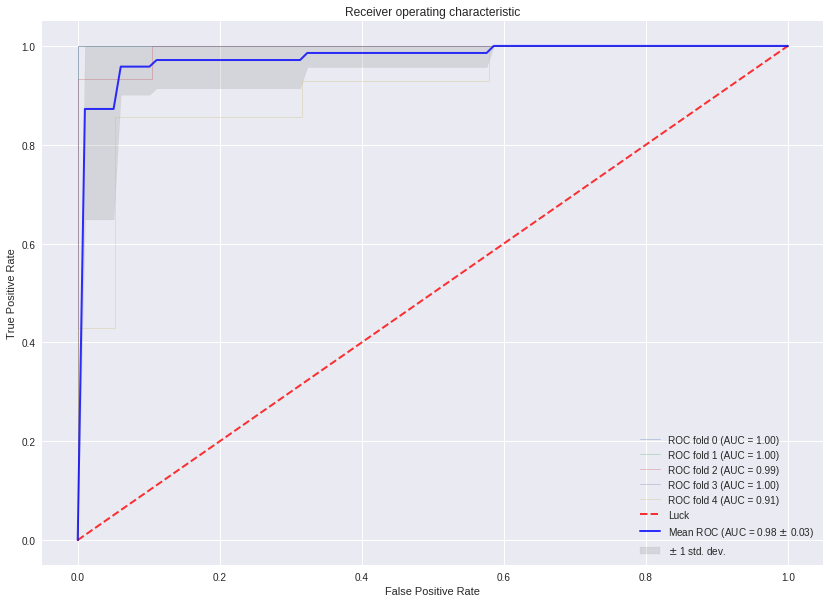

,AUC Train,AUC Test
0,0.984574,1.000000
1,0.984574,1.000000
2,0.987069,0.992982
3,0.985058,1.000000
4,0.997547,0.913534


In [0]:
## cross-validation of clf:

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    RF_model.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])



##Now let's check some values:

In [0]:
##test values:

url_input_1 = 'https://raw.githubusercontent.com/AigerimJ/heart_disease/master/heart/train/train.csv?token=ATmRgDIt8LL9NdjbX091iBYA_RE-QLfkks5clxRpwA%3D%3D'

dataset1 = pd.read_csv(url_input_1)
dataset1.head()

y_test1 = dataset1['result']
X_test1 = dataset1.drop(['patient_id', 'result'], axis = 1)

for i in range(len(X_test1.values)):
  if(X_test1.thal.values[i] == 'normal'):
    X_test1.thal.values[i] = 1
    
  if(X_test1.thal.values[i] == 'fixed_defect'):
    X_test1.thal.values[i] = 2
  
  if(X_test1.thal.values[i] == 'reversible_defect'):
    X_test1.thal.values[i] = 3

 

In [0]:
## cross-fitting:






In [0]:
# predict and show

# Y_pred = np.empty((len(X_test1), 1))

# for i in range(len(X_test1)):
#   Y_pred[i] += RF_model.predict([X_test1.values[i]])
# #   print(i,") Labeled case: %2f" %y_test1.values[i], " Prediction: %2f" %Y_pred[i])
  
# RF_predictions1 = RF_model.predict(X_test1)
# score1 = accuracy_score(y_test1, RF_predictions1)
# print(score1)


Y_pred1 = np.empty((len(X_test1), 1))


# print(clf.predict_proba(X_test1))

for i in range(len(X_test1)):
  Y_pred1[i] += clf.predict_proba([X_test1.values[i]])[:,1]
  print(i,") Labeled case: %2f" %y_test1.values[i], " Prediction_prob: %2f" %Y_pred1[i])
  
clf_predictions1 = clf.predict(X_test1)
score2 = accuracy_score(y_test1, clf_predictions1)
print(score2)

0 ) Labeled case: 0.000000  Prediction_prob: 0.500163
1 ) Labeled case: 0.000000  Prediction_prob: 0.410260
2 ) Labeled case: 1.000000  Prediction_prob: 0.613535
3 ) Labeled case: 1.000000  Prediction_prob: 0.543456
4 ) Labeled case: 1.000000  Prediction_prob: 0.672042
5 ) Labeled case: 1.000000  Prediction_prob: 0.630675
6 ) Labeled case: 0.000000  Prediction_prob: 0.256400
7 ) Labeled case: 1.000000  Prediction_prob: 0.569381
8 ) Labeled case: 1.000000  Prediction_prob: 0.575397
9 ) Labeled case: 1.000000  Prediction_prob: 0.716182
10 ) Labeled case: 0.000000  Prediction_prob: 0.202637
11 ) Labeled case: 0.000000  Prediction_prob: 0.099301
0.9166666666666666


##Now real test goes next:

In [0]:
##test values:

url_input_2 = 'https://raw.githubusercontent.com/AigerimJ/heart_disease/master/heart/test/test_values.csv?token=ATmRgCpws27z69mW58ssz9qNFaZwrnBVks5cllChwA%3D%3D'

dataset2 = pd.read_csv(url_input_2)
dataset2.head()

X_test2 = dataset2.drop(['patient_id'], axis = 1)

for i in range(len(X_test2.values)):
  if(X_test2.thal.values[i] == 'normal'):
    X_test2.thal.values[i] = 1
    
  if(X_test2.thal.values[i] == 'fixed_defect'):
    X_test2.thal.values[i] = 2
  
  if(X_test2.thal.values[i] == 'reversible_defect'):
    X_test2.thal.values[i] = 3

In [0]:
# predict and show

Y_pred2 = np.empty((len(X_test2), 1))

for i in range(len(X_test2)):
  Y_pred2[i] += clf.predict_proba([X_test2.values[i]])[:,1]
  
  print(i,") Labeled case: %2f" %Y_pred2[i])
  
# Y_pred2.to_csv('csv_example')
# print(Y_pred2)
 
# with open("output.csv", "wb") as f:
#     writer = csv.writer(f)
#     writer.writerows(Y_pred2)

0 ) Labeled case: 0.378631
1 ) Labeled case: 0.193516
2 ) Labeled case: 0.948531
3 ) Labeled case: 0.162268
4 ) Labeled case: 0.885356
5 ) Labeled case: 0.018213
6 ) Labeled case: 0.336448
7 ) Labeled case: 0.781979
8 ) Labeled case: 0.248552
9 ) Labeled case: 0.128894
10 ) Labeled case: 0.386116
11 ) Labeled case: 0.516358
12 ) Labeled case: 0.324427
13 ) Labeled case: 0.833626
14 ) Labeled case: 0.198000
15 ) Labeled case: 0.049597
16 ) Labeled case: 0.097376
17 ) Labeled case: 0.283380
18 ) Labeled case: 0.862112
19 ) Labeled case: 0.066919
20 ) Labeled case: 0.956558
21 ) Labeled case: 0.134276
22 ) Labeled case: 0.213006
23 ) Labeled case: 0.046240
24 ) Labeled case: 0.594899
25 ) Labeled case: 0.927730
26 ) Labeled case: 0.618908
27 ) Labeled case: 0.252062
28 ) Labeled case: 0.538289
29 ) Labeled case: 0.019447
30 ) Labeled case: 0.792212
31 ) Labeled case: 0.450808
32 ) Labeled case: 0.632654
33 ) Labeled case: 0.332689
34 ) Labeled case: 0.225740
35 ) Labeled case: 0.165645
36